Using device: cuda
Checking for dataset...
Dataset already downloaded.
Training data: 5216 images
Validation data: 16 images
--- Training Linear Probing ---


Epoch 1/1:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 1 | Validation AUC: 1.0000
Finished Training Linear Probing. Total time: 41.84s
--- Training Full Fine-Tuning ---


Epoch 1/1:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 1 | Validation AUC: 1.0000
Finished Training Full Fine-Tuning. Total time: 42.38s
trainable params: 1,303,888 || all params: 24,816,018 || trainable%: 5.2542
--- Training Adapter (LoRA) ---


Epoch 1/1:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 1 | Validation AUC: 0.9375
Finished Training Adapter (LoRA). Total time: 42.06s

--- Comparison Summary ---
             Method  Final AUC  Training Time (s)  Trainable Params
0    Linear Probing     1.0000          41.844429              4098
1  Full Fine-Tuning     1.0000          42.375136          23512130
2    Adapter (LoRA)     0.9375          42.062749           1303888


/tmp/ipython-input-1120123551.py:183: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Method', y='Final AUC', data=results_df, ax=axes[0], palette='viridis')
/tmp/ipython-input-1120123551.py:189: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Method', y='Training Time (s)', data=results_df, ax=axes[1], palette='plasma')
/tmp/ipython-input-1120123551.py:194: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Method', y='Trainable Params', data=results_df, ax=axes[2], palette='magma')


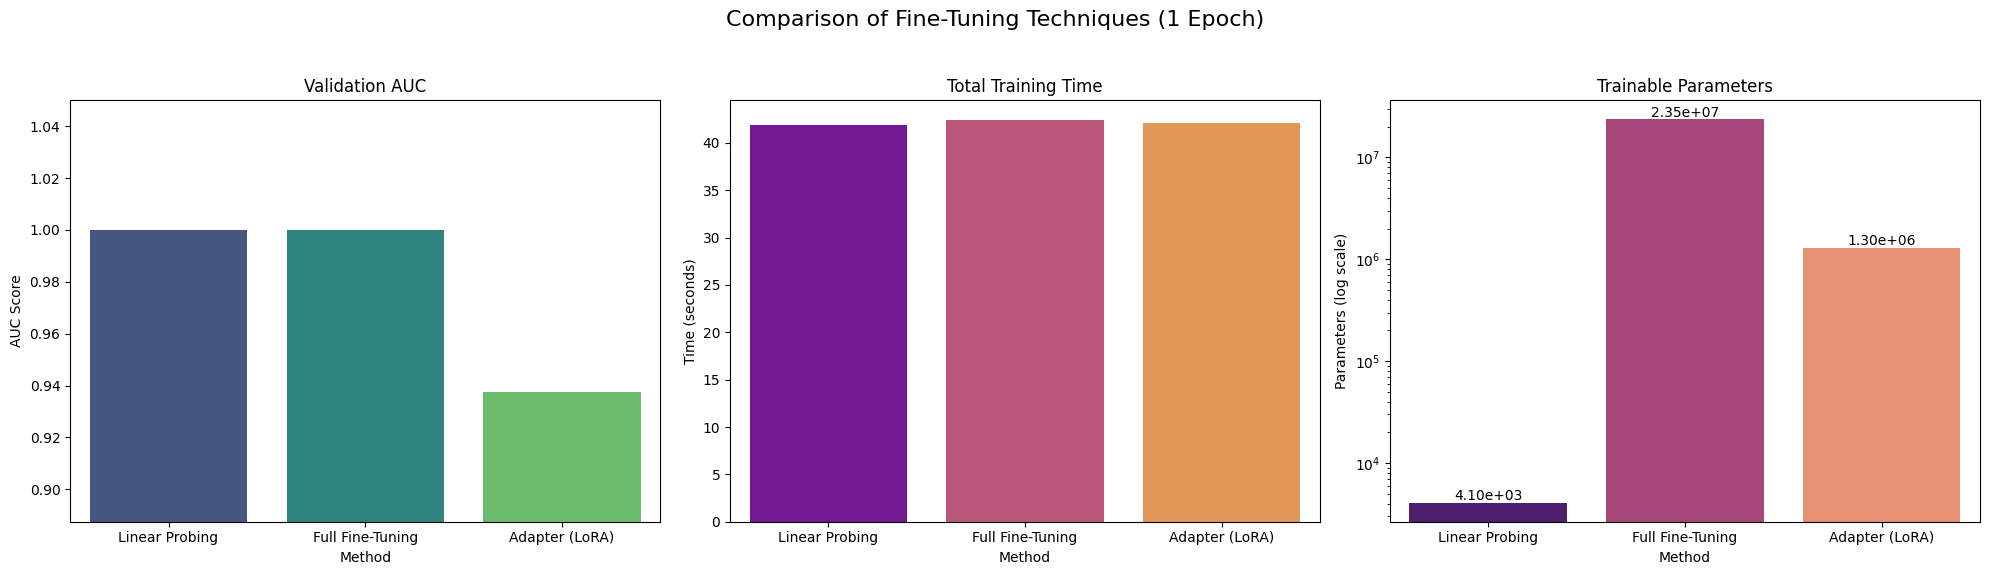

In [8]:

#  SETUP AND DEPENDENCIES
!pip install -q opendatasets pandas scikit-learn peft
!pip install -q --upgrade accelerate

import os
import time
import opendatasets as od
import pandas as pd
from PIL import Image
import numpy as np
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import models, transforms, datasets
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns
from peft import get_peft_model, LoraConfig

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# 1. DATASET PREPARATION (RELIABLE METHOD)
print("Checking for dataset...")
# This is the URL of the dataset's Kaggle page
dataset_path = './chest-xray-pneumonia'
if not os.path.exists(dataset_path):
    print("Downloading dataset using opendatasets library...")
    dataset_url = 'https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia'
    od.download(dataset_url)
    print("Dataset downloaded successfully.")
else:
    print("Dataset already downloaded.")

# Define paths and image transformations
# The library creates a folder with the dataset name
DATA_DIR = './chest-xray-pneumonia/chest_xray'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VAL_DIR = os.path.join(DATA_DIR, 'val')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Use ImageFolder to easily load the dataset from the folder structure
train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=transform)
val_dataset = datasets.ImageFolder(VAL_DIR, transform=transform)

# Create DataLoaders for batching
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f"Training data: {len(train_dataset)} images")
print(f"Validation data: {len(val_dataset)} images")


# 2. UTILITY FUNCTIONS FOR TRAINING AND EVALUATION

def train_model(model, train_loader, val_loader, epochs=1, lr=1e-4, model_name="Model"):
    """Generic training loop to train a model and record results."""
    # Only pass parameters that require gradients to the optimizer
    optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    criterion = nn.CrossEntropyLoss()
    model.to(device)

    results = {'name': model_name, 'val_auc': []}
    start_time = time.time()

    print(f"--- Training {model_name} ---")
    for epoch in range(epochs):
        model.train()
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        val_auc = evaluate_model(model, val_loader)
        results['val_auc'].append(val_auc)
        print(f"Epoch {epoch+1} | Validation AUC: {val_auc:.4f}")

    end_time = time.time()
    results['time'] = end_time - start_time
    results['params'] = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"Finished Training {model_name}. Total time: {results['time']:.2f}s")
    return results

def evaluate_model(model, val_loader):
    """Generic evaluation loop to calculate AUC."""
    model.eval()
    all_labels, all_probs = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)[:, 1] # Probability of class 1
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    return roc_auc_score(all_labels, all_probs)

all_results = []


# 3. METHOD 1: LINEAR PROBING

model_lp = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
for param in model_lp.parameters():
    param.requires_grad = False

num_ftrs = model_lp.fc.in_features
model_lp.fc = nn.Linear(num_ftrs, 2)
model_lp.fc.requires_grad_(True)

results_lp = train_model(model_lp, train_loader, val_loader, epochs=1, lr=1e-3, model_name="Linear Probing")
all_results.append(results_lp)


# 4. METHOD 2: FULL FINE-TUNING

model_ft = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

results_ft = train_model(model_ft, train_loader, val_loader, epochs=1, lr=1e-5, model_name="Full Fine-Tuning")
all_results.append(results_ft)


# 5. METHOD 3: ADAPTER-BASED TUNING (LoRA) - CORRECTED

model_lora_base = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
num_ftrs = model_lora_base.fc.in_features
model_lora_base.fc = nn.Linear(num_ftrs, 2)

# Define LoRA configuration
# CORRECTED: Find all Linear and Conv2d layers programmatically to give LoRA
# a valid list of modules to adapt.
target_modules = []
for name, module in model_lora_base.named_modules():
    if isinstance(module, (nn.Linear, nn.Conv2d)):
        target_modules.append(name)

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=target_modules, # Use the corrected list of modules
    lora_dropout=0.1,
    bias="none",
)

model_lora = get_peft_model(model_lora_base, lora_config)
model_lora.print_trainable_parameters()

results_lora = train_model(model_lora, train_loader, val_loader, epochs=1, lr=1e-3, model_name="Adapter (LoRA)")
all_results.append(results_lora)


# 6. RESULTS AND CONCLUSION

results_df = pd.DataFrame({
    "Method": [r['name'] for r in all_results],
    "Final AUC": [r['val_auc'][-1] for r in all_results],
    "Training Time (s)": [r['time'] for r in all_results],
    "Trainable Params": [r['params'] for r in all_results]
})

print("\n--- Comparison Summary ---")
print(results_df)

# Plotting the results
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Comparison of Fine-Tuning Techniques (1 Epoch)', fontsize=16)

# AUC Plot
sns.barplot(x='Method', y='Final AUC', data=results_df, ax=axes[0], palette='viridis')
axes[0].set_title('Validation AUC')
axes[0].set_ylabel('AUC Score')
axes[0].set_ylim(bottom=max(0.5, results_df['Final AUC'].min() - 0.05))

# Training Time Plot
sns.barplot(x='Method', y='Training Time (s)', data=results_df, ax=axes[1], palette='plasma')
axes[1].set_title('Total Training Time')
axes[1].set_ylabel('Time (seconds)')

# Trainable Parameters Plot
ax = sns.barplot(x='Method', y='Trainable Params', data=results_df, ax=axes[2], palette='magma')
axes[2].set_title('Trainable Parameters')
ax.set_ylabel('Parameters (log scale)')
ax.set_yscale('log')
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2e}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Based on the results from a one epoch experiment, a comparative analysis of the two fine-tuning strategies reveals a trade-off between model performance and computational efficiency.

While full fine-tuning achieved superior predictive accuracy by attaining a perfect validation AUC of 1.0000, the adapter-based LoRA method had a slightly lower yet strong AUC of 0.9375.

The training times were nearly identical (~42 seconds for both), an artifact likely attributable to data I/O and loading overhead masking the computational differences in a short training run.

The distinction lies in parameter efficiency: full fine-tuning updated the entire set of ~23.5 million parameters, whereas LoRA modified a mere ~1.3 million. This shows that while fully adapting a model's weights can maximize performance on a specific task, parameter-efficient methods like LoRA provide a compelling alternative, achieving competitive results with a much smaller memory and computational footprint, making them suitable for scenarios that need efficient deployment and multitask adaptation.